In [1]:
import gym
import gym_anytrading

from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
import matplotlib.pyplot as plt
from keras import applications
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, Input, Concatenate, Conv2D
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.agents.ddpg import DDPGAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.random import OrnsteinUhlenbeckProcess
from rl.callbacks import FileLogger, ModelIntervalCheckpoint, TrainIntervalLogger
from rl.processors import WhiteningNormalizerProcessor

from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

import json
import numpy as np

Using TensorFlow backend.
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\py

### Using Forex-v0 with all features available and diffs

In [2]:
from custom_env import ForexV0FullFeature
def env_creator():
    return ForexV0FullFeature(df=FOREX_EURUSD_1H_ASK, frame_bound=(50, 5000), window_size=24)

env = env_creator()
print(env.df)
obs = env.reset()
obs_shape = obs.shape
nb_actions = env.action_space.n

def buildModel():
    model = Sequential()
    model.add(Flatten(input_shape=(1,) + obs_shape))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(nb_actions, activation='linear'))
    return model
buildModel().summary()

def agent_creator():
    processor = WhiteningNormalizerProcessor()
    memory = SequentialMemory(limit=256, window_length=1)
    policy = BoltzmannQPolicy()
    agent = DQNAgent(model=buildModel(), nb_actions=nb_actions, memory=memory, nb_steps_warmup=128, policy=policy, batch_size=64, processor=processor, 
                   target_model_update=1e-2, train_interval=32, gamma=0.5, enable_double_dqn=False)
    agent.compile(Adam(lr=0.001), metrics=['mae'])
    return agent

                            Open     High      Low    Close        Volume
Time                                                                     
01.01.2017 22:00:00.000  1.05236  1.05253  1.05221  1.05227  1.435400e+08
01.01.2017 23:00:00.000  1.05227  1.05426  1.05226  1.05282  2.531400e+08
02.01.2017 00:00:00.000  1.05283  1.05283  1.05268  1.05281  1.314000e+08
02.01.2017 01:00:00.000  1.05282  1.05286  1.05225  1.05240  2.739400e+08
02.01.2017 02:00:00.000  1.05239  1.05240  1.05164  1.05220  2.581400e+08
...                          ...      ...      ...      ...           ...
29.12.2017 17:00:00.000  1.20224  1.20257  1.20191  1.20218  9.283300e+09
29.12.2017 18:00:00.000  1.20218  1.20242  1.20122  1.20139  7.366750e+09
29.12.2017 19:00:00.000  1.20139  1.20144  1.20073  1.20096  7.205770e+09
29.12.2017 20:00:00.000  1.20098  1.20109  1.19978  1.19982  6.679810e+09
29.12.2017 21:00:00.000  1.19984  1.20130  1.19931  1.20075  4.885530e+09

[6225 rows x 5 columns]
Instructions 

starting train 1
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
147/989 [===>..........................] - ETA: 3s - reward: 0.5122 - cumulative_reward: 115.4320WARNING:tensorflow:From d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\ops\math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
989/989 [==============================] - 17s 18ms/step - reward: -0.7554 - cumulative_reward: -556.8509
train 1 completed. took 18.171 seconds, total_reward: -747.6999999999585 total_profit: 0.828927571311597
min reward: -314.0999999999994, max reward: 474.0000000000011, mean_reward: -0.15108102646998556


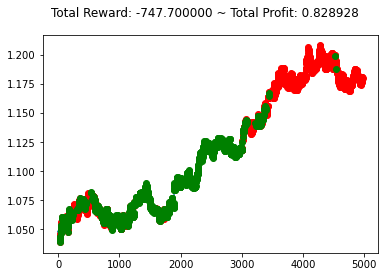

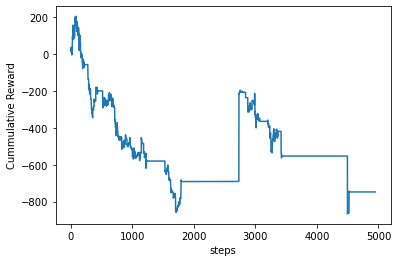

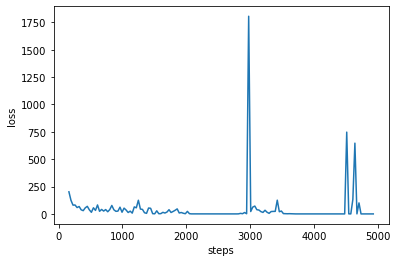

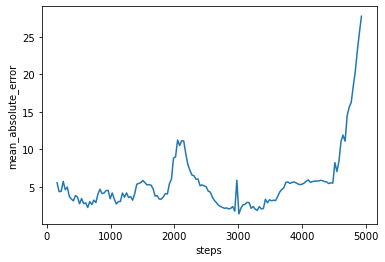

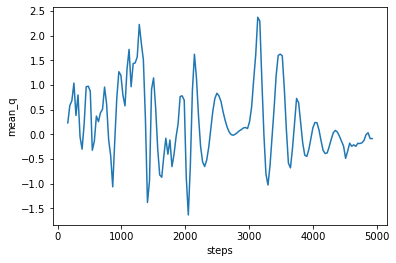

starting train 2
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 16s 17ms/step - reward: -0.7669 - cumulative_reward: -545.8853
train 2 completed. took 36.362 seconds, total_reward: -759.1000000000275 total_profit: 0.8313197801132901
min reward: -162.5999999999994, max reward: 128.50000000000028, mean_reward: -0.1533845221256875


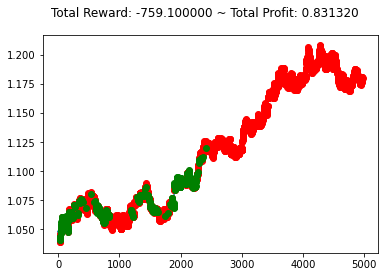

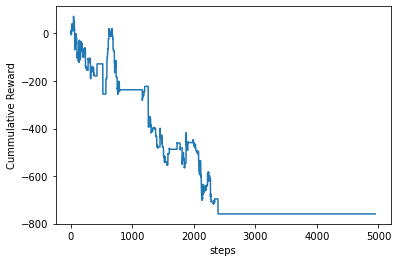

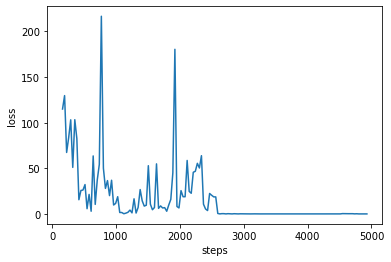

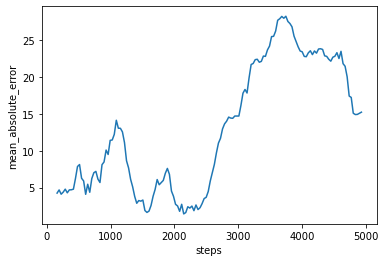

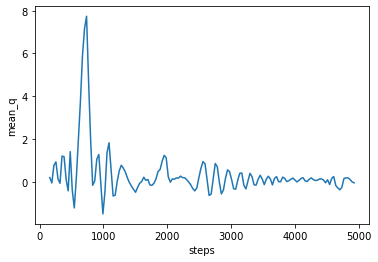

starting train 3
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 17s 17ms/step - reward: 14.7523 - cumulative_reward: -147.5967
train 3 completed. took 54.846 seconds, total_reward: -245.20000000002932 total_profit: 0.7816755515018193
min reward: -162.1000000000006, max reward: 151.60000000000062, mean_reward: -0.049545362699541184


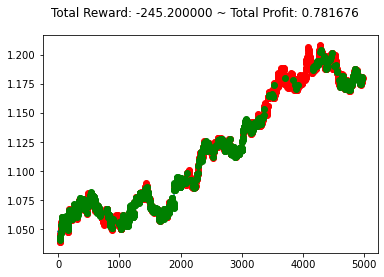

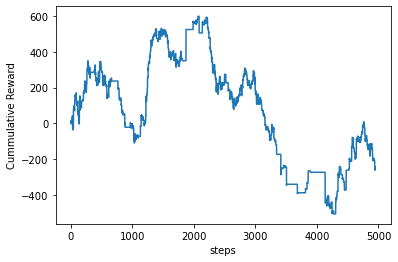

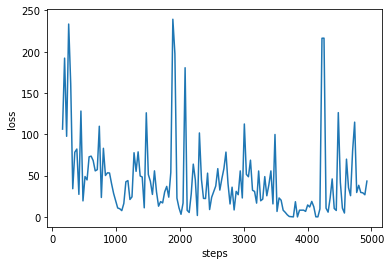

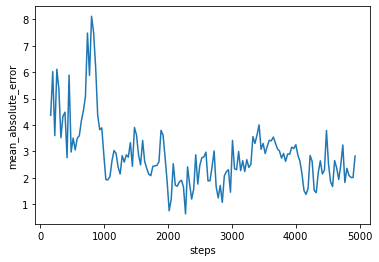

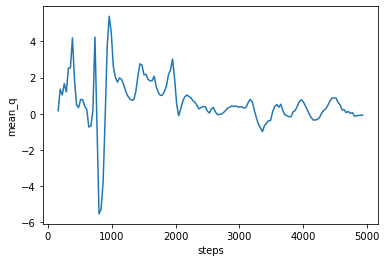

starting train 4
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 18s 18ms/step - reward: -2.5012 - cumulative_reward: -229.4412
train 4 completed. took 74.180 seconds, total_reward: -1.1999999999784556 total_profit: 0.843876999659135
min reward: -204.09999999999818, max reward: 195.19999999999982, mean_reward: -0.00024247322691017492


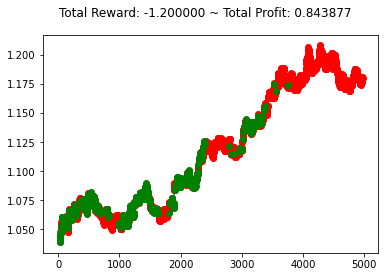

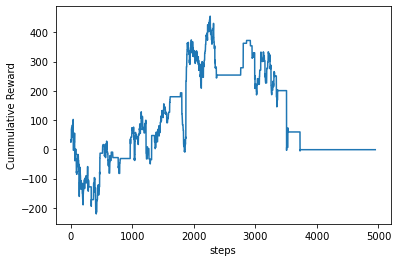

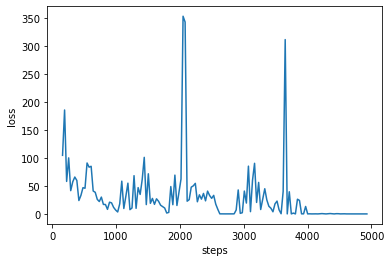

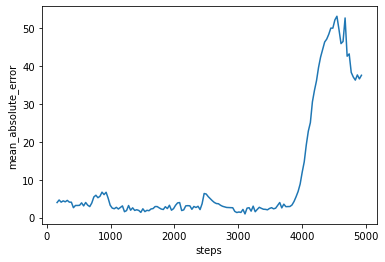

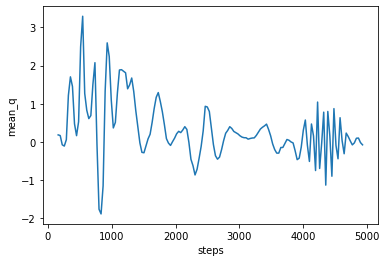

starting train 5
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 18s 18ms/step - reward: 0.2441 - cumulative_reward: 324.4559
train 5 completed. took 93.759 seconds, total_reward: 241.5999999999591 total_profit: 0.934302939569543
min reward: -95.09999999999907, max reward: 113.60000000000036, mean_reward: 0.04881794301878341


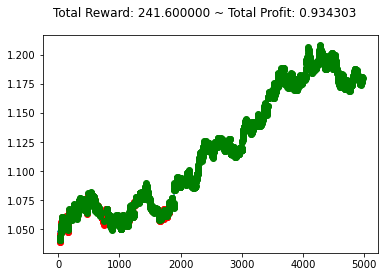

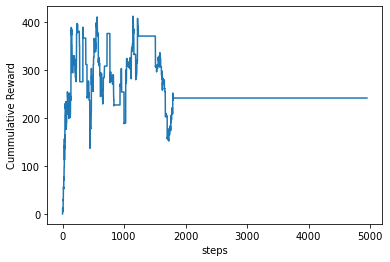

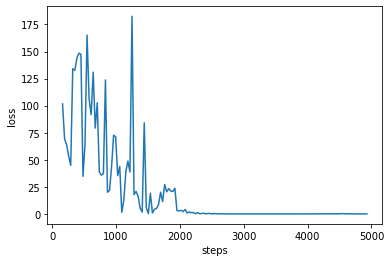

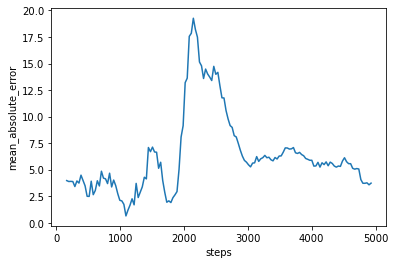

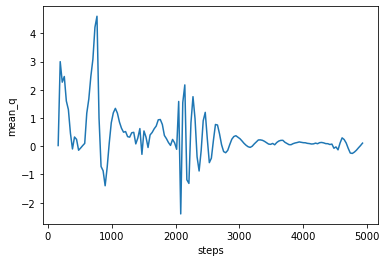

starting train 6
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 18s 19ms/step - reward: -0.7797 - cumulative_reward: -431.3648
train 6 completed. took 114.144 seconds, total_reward: -771.6999999999796 total_profit: 0.8450514453114027
min reward: -247.00000000000165, max reward: 179.60000000000198, mean_reward: -0.15593049100828038


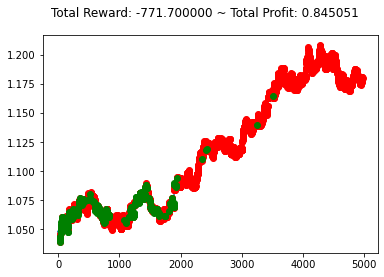

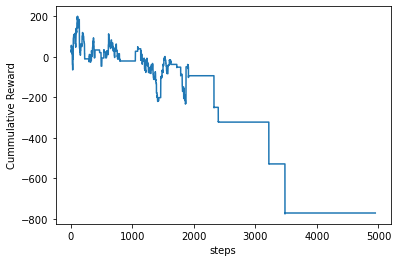

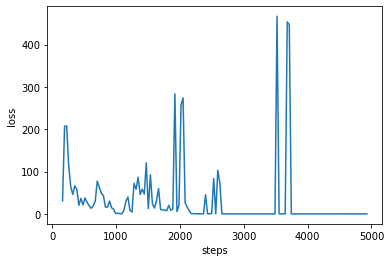

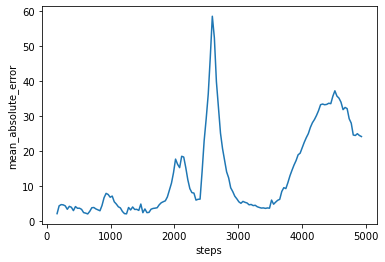

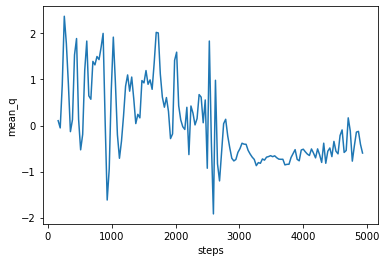

starting train 7
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 19s 19ms/step - reward: -0.3533 - cumulative_reward: -126.1675
train 7 completed. took 135.254 seconds, total_reward: -349.699999999944 total_profit: 0.8545538485809024
min reward: -463.7000000000002, max reward: 81.2999999999997, mean_reward: -0.07066073954333077


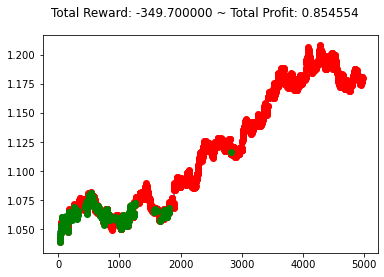

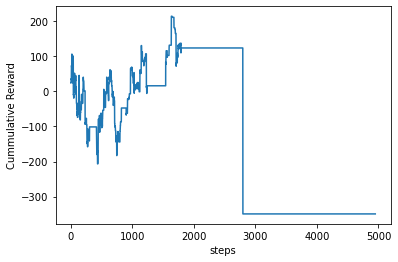

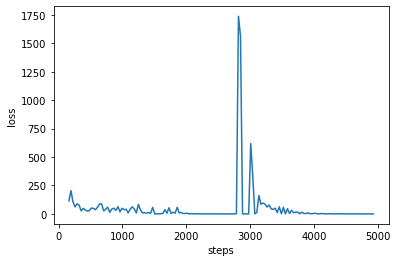

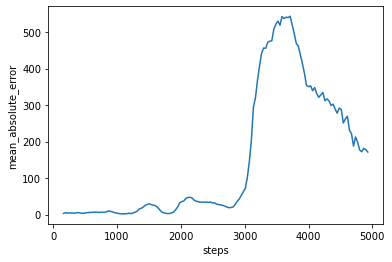

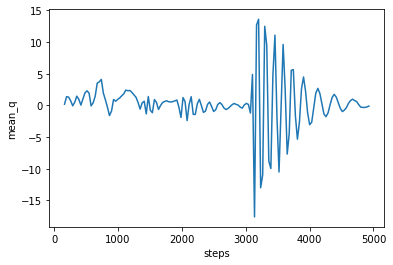

starting train 8
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 19s 19ms/step - reward: 1.0183 - cumulative_reward: 534.8939
train 8 completed. took 156.198 seconds, total_reward: 1007.9000000000171 total_profit: 0.8838867977332256
min reward: -205.7999999999982, max reward: 655.5, mean_reward: 0.20365730450596425


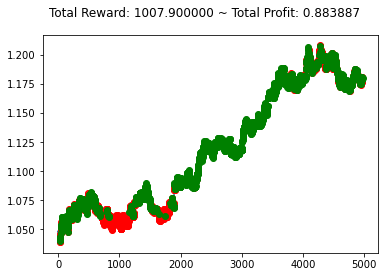

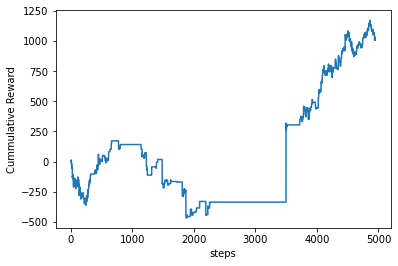

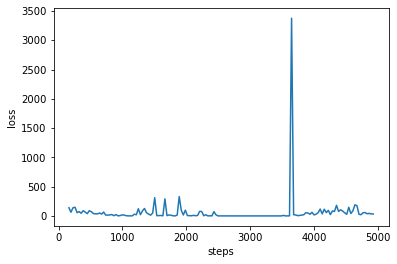

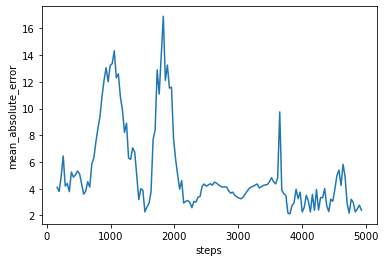

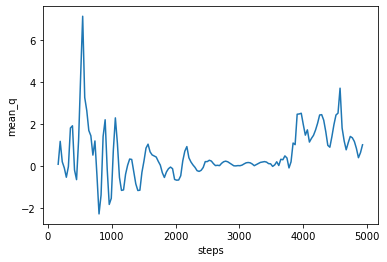

starting train 9
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 19s 19ms/step - reward: 21.5172 - cumulative_reward: -356.0233 10s - reward: 34.4736 - cumu
train 9 completed. took 177.808 seconds, total_reward: -675.7999999999413 total_profit: 0.797550923606536
min reward: -93.89999999999787, max reward: 203.40000000000026, mean_reward: -0.13655283895735326


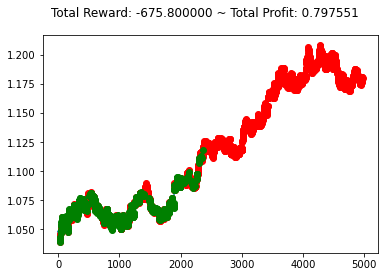

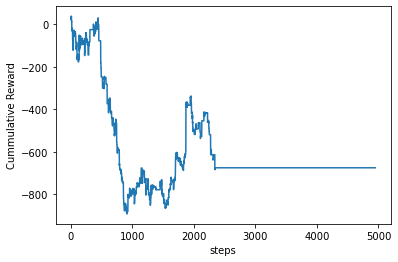

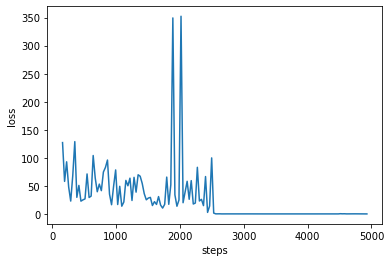

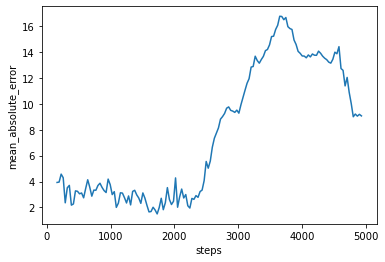

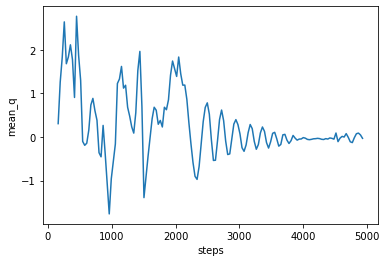

starting train 10
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 21s 21ms/step - reward: 22.5065 - cumulative_reward: 165.7760
train 10 completed. took 200.941 seconds, total_reward: 600.3000000000578 total_profit: 0.872916732360832
min reward: -151.70000000000127, max reward: 486.1000000000004, mean_reward: 0.1212972317640044


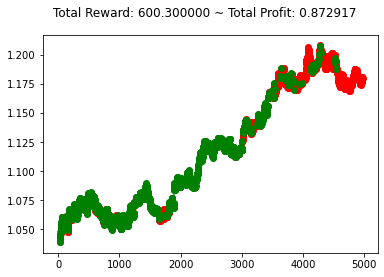

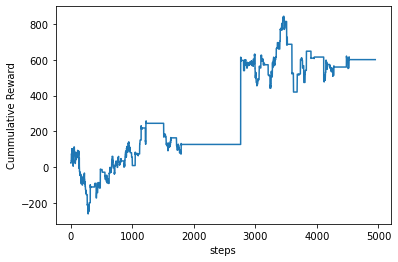

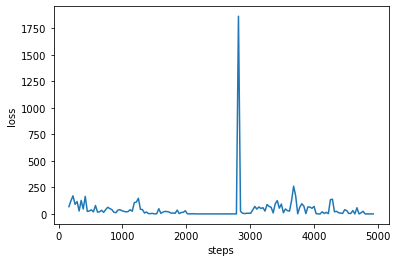

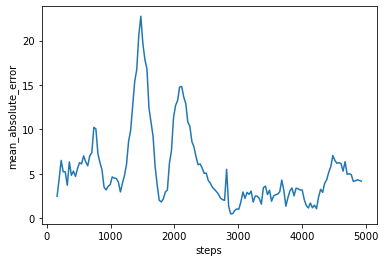

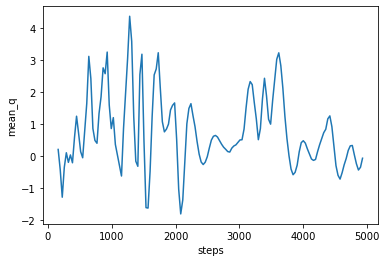

In [3]:
from evaluator import Evaluator

e = Evaluator(agent_creator, env_creator, name="dqn")
e.train(repeat=10)


average of total_reward across trainings: [-170.06]


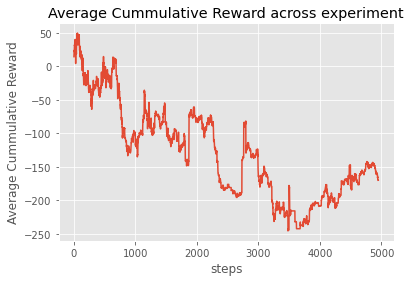

Testing for 1 episodes ...
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
192/199 [===========================>..] - ETA: 0s - reward: 2.5944 - cumulative_reward: 285.2884Episode 1: reward: 460.400, steps: 999
test completed. total_reward: 460.4000000000342 total_profit: 0.9997307681670083
min reward: -183.10000000000048, max reward: 70.99999999999883, mean_reward: 0.4608608608608951


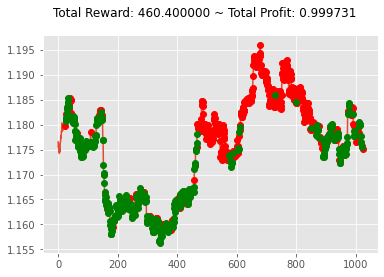

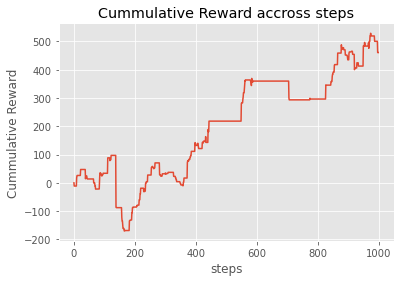

In [4]:
e.process_train_result()
e.test(ForexV0FullFeature(df=FOREX_EURUSD_1H_ASK, frame_bound=(5000, 6000), window_size=24))

### Double DQN

In [5]:

def agent_creator():
    #processor = EnvProcessor()
    processor = WhiteningNormalizerProcessor()
    memory = SequentialMemory(limit=256, window_length=1)
    #policy = EpsGreedyQPolicy()
    policy = BoltzmannQPolicy()
    agent = DQNAgent(model=buildModel(), nb_actions=nb_actions, memory=memory, nb_steps_warmup=128, policy=policy, batch_size=64, processor=processor, 
                   target_model_update=1e-2, train_interval=32, gamma=0.5, enable_double_dqn=True)
    agent.compile(Adam(lr=0.001), metrics=['mae'])
    return agent

starting train 1
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 21s 21ms/step - reward: -13.5122 - cumulative_reward: -20.8466
train 1 completed. took 22.556 seconds, total_reward: -309.0000000000219 total_profit: 0.9181324682783362
min reward: -129.60000000000082, max reward: 84.90000000000109, mean_reward: -0.06243685593049543


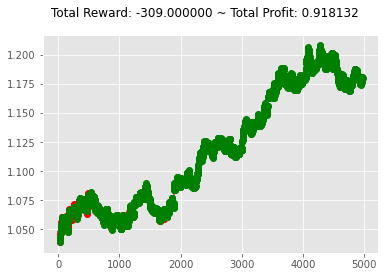

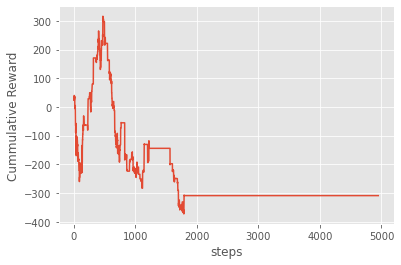

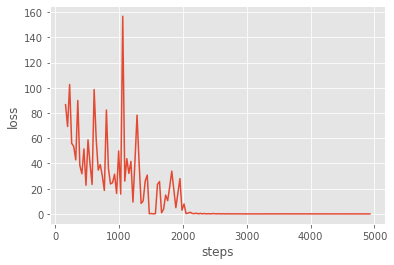

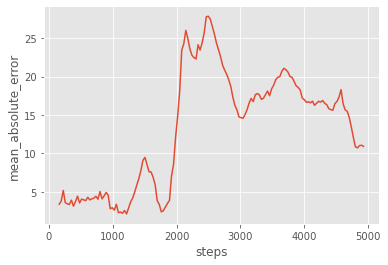

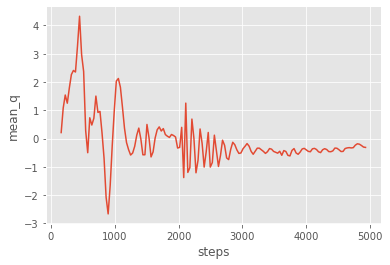

starting train 2
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 24s 24ms/step - reward: -12.2149 - cumulative_reward: 542.2414
train 2 completed. took 50.012 seconds, total_reward: 876.10000000003 total_profit: 0.8849708405175551
min reward: -144.10000000000034, max reward: 389.60000000000105, mean_reward: 0.1770256617498545


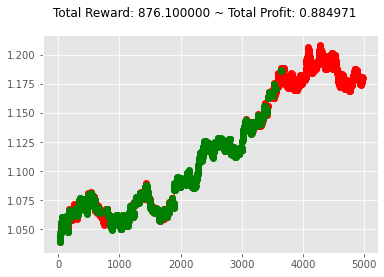

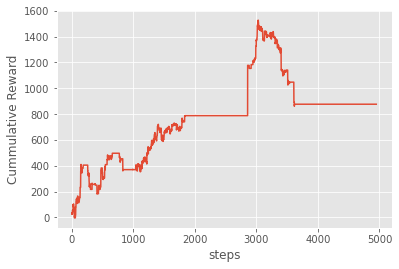

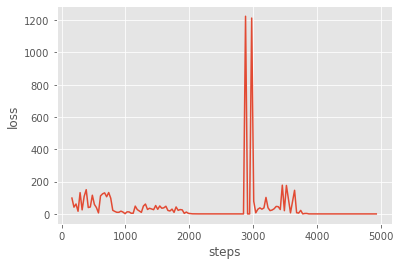

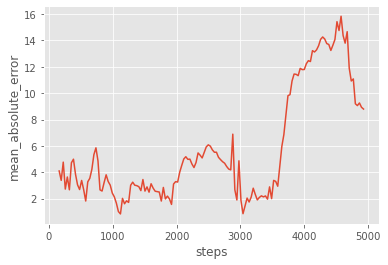

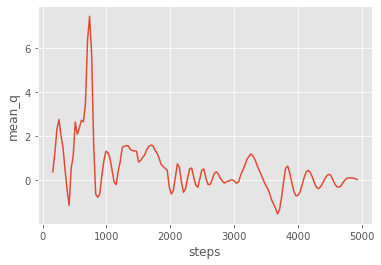

starting train 3
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 24s 24ms/step - reward: 11.0027 - cumulative_reward: 301.2838
train 3 completed. took 77.430 seconds, total_reward: 497.59999999998905 total_profit: 0.7741496714377241
min reward: -129.5999999999986, max reward: 156.40000000000097, mean_reward: 0.10054556476055547


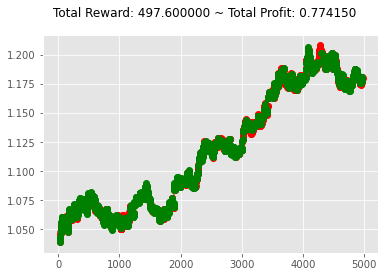

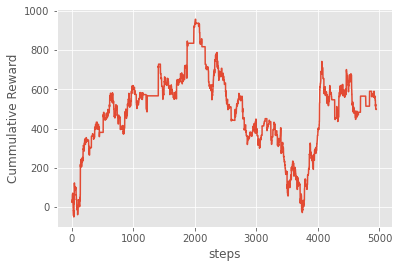

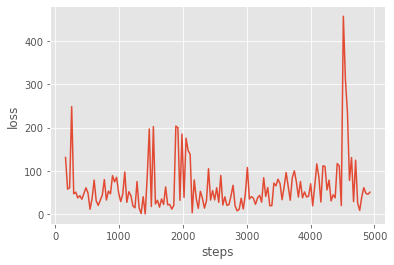

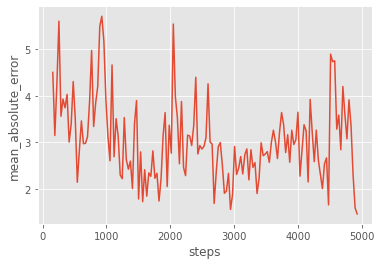

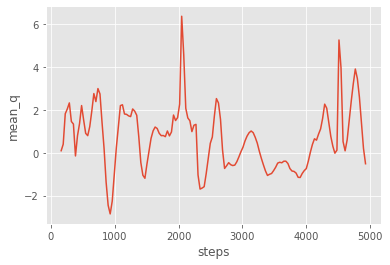

starting train 4
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 27s 27ms/step - reward: -0.1916 - cumulative_reward: -95.2484
train 4 completed. took 107.827 seconds, total_reward: -189.59999999998112 total_profit: 0.813035455703956
min reward: -168.70000000000164, max reward: 113.79999999999946, mean_reward: -0.03831076985249164


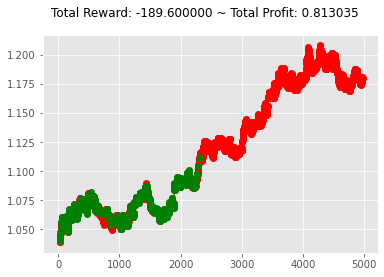

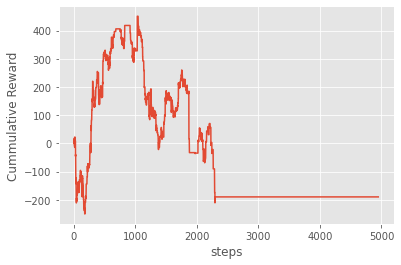

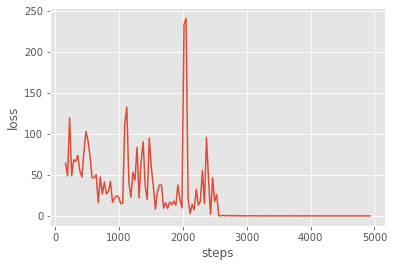

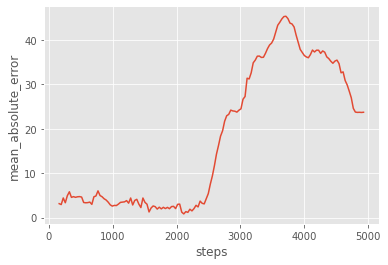

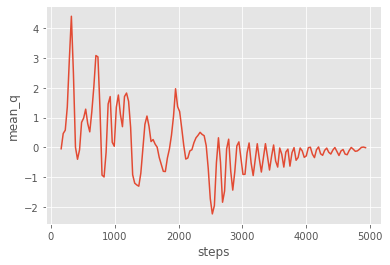

starting train 5
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 27s 28ms/step - reward: -0.8626 - cumulative_reward: -694.5252
train 5 completed. took 138.924 seconds, total_reward: -853.8000000000579 total_profit: 0.8219297845181005
min reward: -200.70000000000033, max reward: 78.00000000000028, mean_reward: -0.1725197009496985


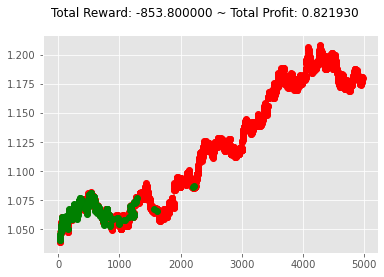

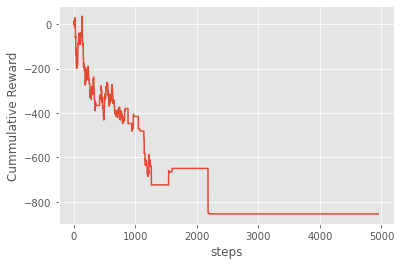

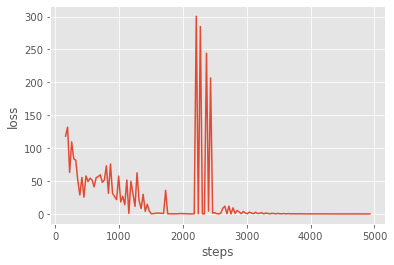

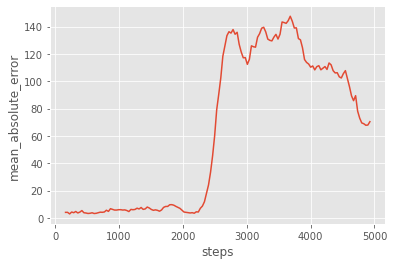

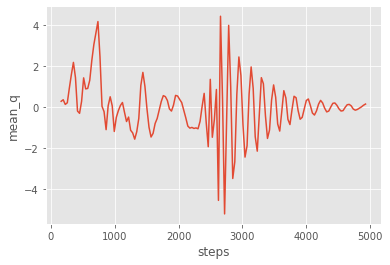

starting train 6
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 27s 28ms/step - reward: -0.9551 - cumulative_reward: -602.0601
train 6 completed. took 170.057 seconds, total_reward: -945.399999999983 total_profit: 0.8118917311410774
min reward: -257.40000000000094, max reward: 110.89999999999822, mean_reward: -0.19102849060415902


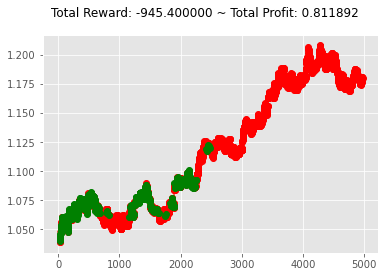

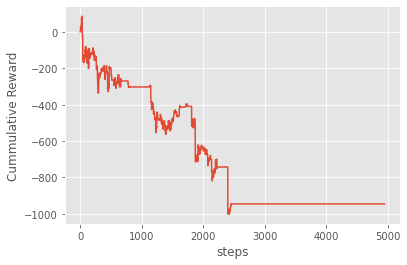

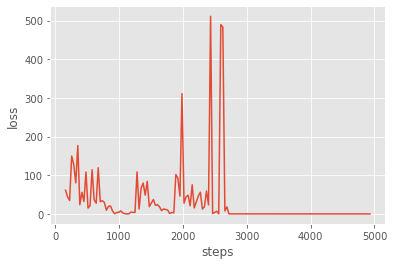

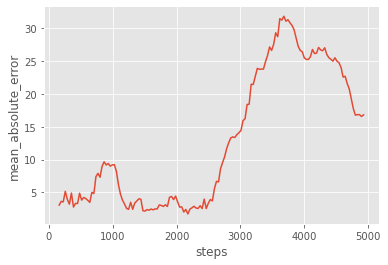

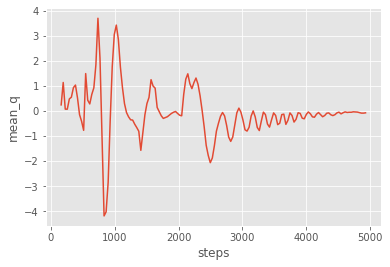

starting train 7
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 27s 28ms/step - reward: 1.0237 - cumulative_reward: 573.5153
train 7 completed. took 201.322 seconds, total_reward: 1013.3000000000479 total_profit: 0.9634763661002652
min reward: -62.3000000000018, max reward: 531.5999999999988, mean_reward: 0.20474843402708587


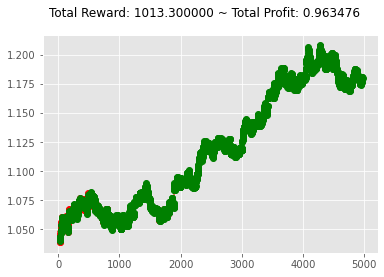

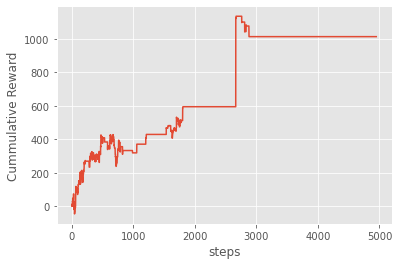

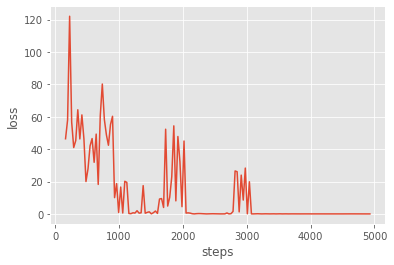

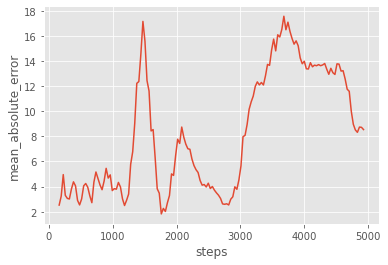

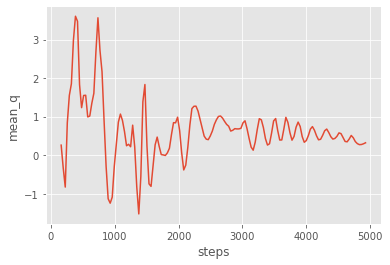

starting train 8
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 24s 24ms/step - reward: -0.4287 - cumulative_reward: -303.8710
train 8 completed. took 229.325 seconds, total_reward: -424.29999999997744 total_profit: 0.8534790472094121
min reward: -228.69999999999945, max reward: 150.69999999999916, mean_reward: -0.08573449181652404


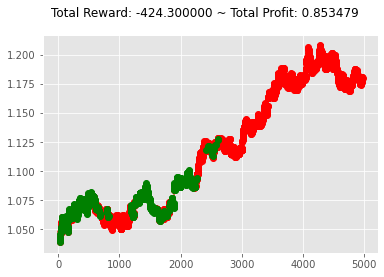

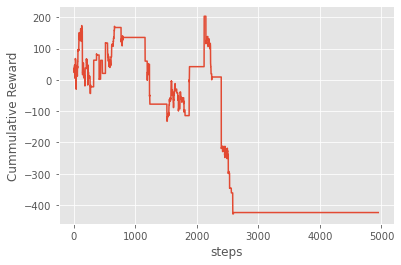

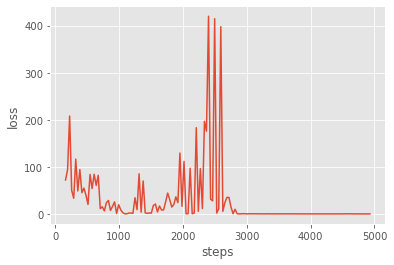

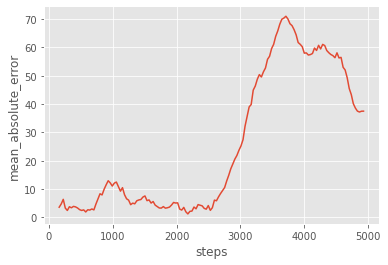

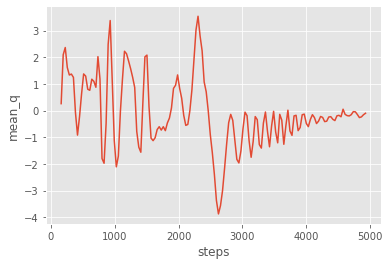

starting train 9
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 26s 26ms/step - reward: 0.4156 - cumulative_reward: 259.5184
train 9 completed. took 259.263 seconds, total_reward: 411.3999999999795 total_profit: 0.8638223895502475
min reward: -65.10000000000016, max reward: 116.39999999999873, mean_reward: 0.08312790462719327


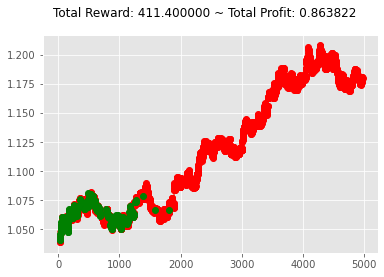

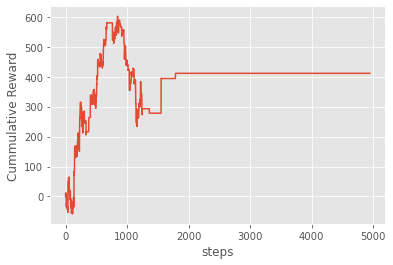

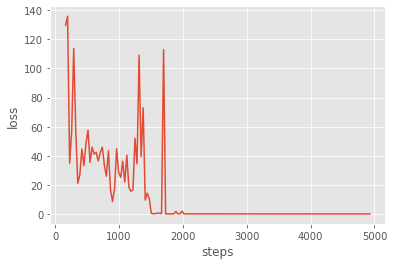

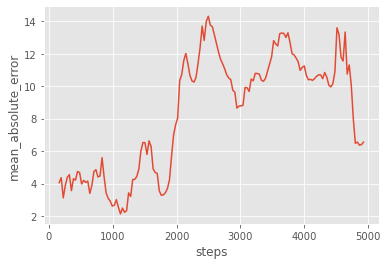

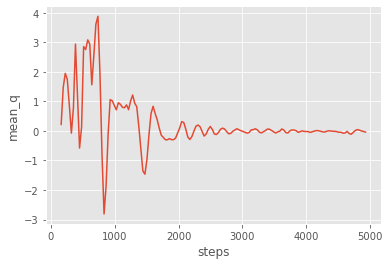

starting train 10
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 57s 57ms/step - reward: 8.2511 - cumulative_reward: 619.7163
train 10 completed. took 324.242 seconds, total_reward: 1436.2999999999843 total_profit: 0.9369309148924314
min reward: -94.39999999999893, max reward: 1004.6999999999983, mean_reward: 0.29022024651444417


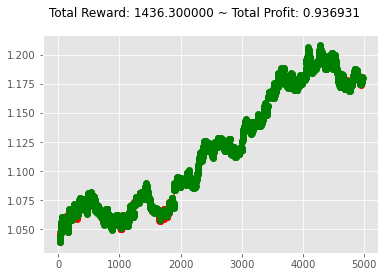

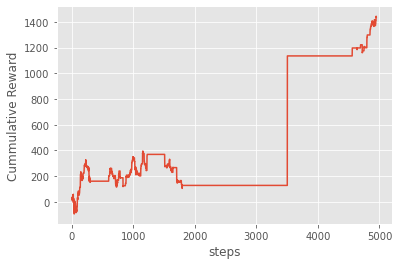

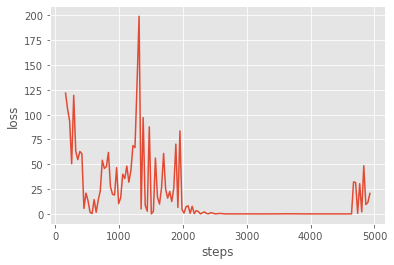

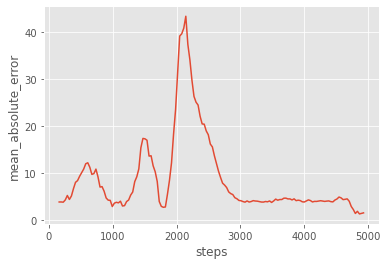

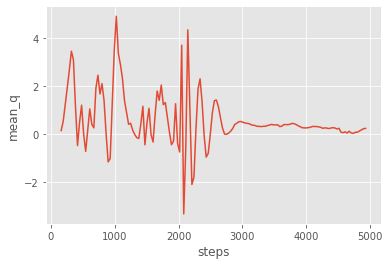

In [6]:
e = Evaluator(agent_creator, env_creator, name="doubledqn")
e.train(repeat=10)

average of total_reward across trainings: [151.26]


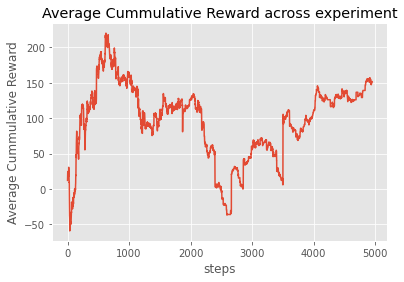

Testing for 1 episodes ...
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
196/199 [============================>.] - ETA: 0s - reward: -0.2683 - cumulative_reward: -9.7223Episode 1: reward: -52.800, steps: 999
test completed. total_reward: -52.79999999998827 total_profit: 0.9758984088384807
min reward: -181.19999999999914, max reward: 127.80000000000236, mean_reward: -0.052852852852841116


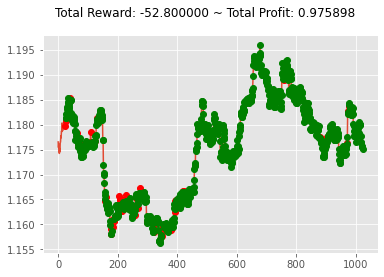

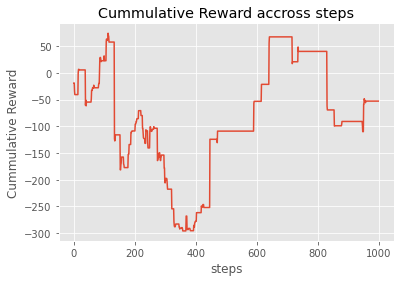

In [7]:
e.process_train_result()
e.test(ForexV0FullFeature(df=FOREX_EURUSD_1H_ASK, frame_bound=(5000, 6000), window_size=24))

### Dueling DQN

starting train 1
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 67s 67ms/step - reward: 12.9064 - cumulative_reward: 145.8762
train 1 completed. took 74.600 seconds, total_reward: -92.59999999997633 total_profit: 0.833339276220627
min reward: -109.89999999999833, max reward: 168.70000000000164, mean_reward: -0.01871085067689964


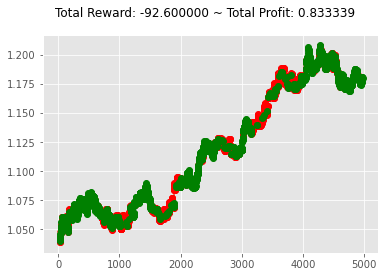

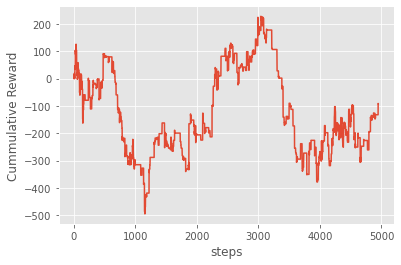

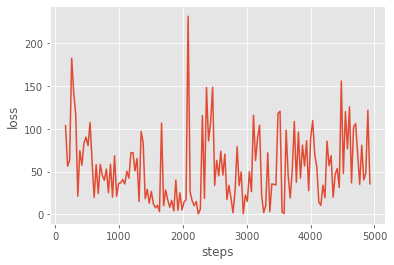

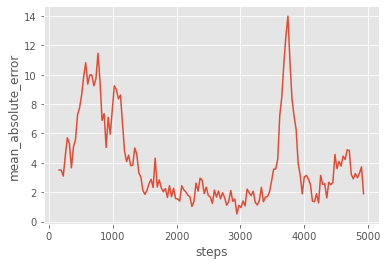

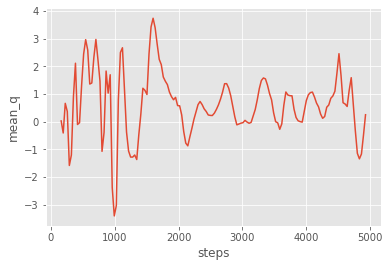

starting train 2
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 63s 64ms/step - reward: 11.7395 - cumulative_reward: -414.6874
train 2 completed. took 151.690 seconds, total_reward: -356.79999999997943 total_profit: 0.8161841642738664
min reward: -157.6999999999984, max reward: 152.90000000000248, mean_reward: -0.07209537280258223


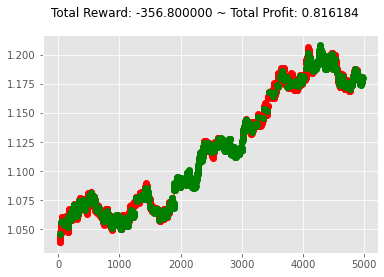

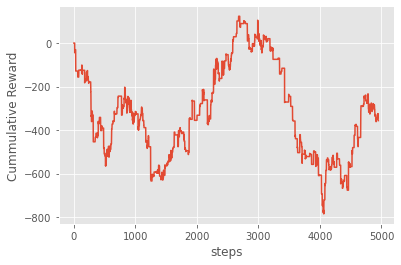

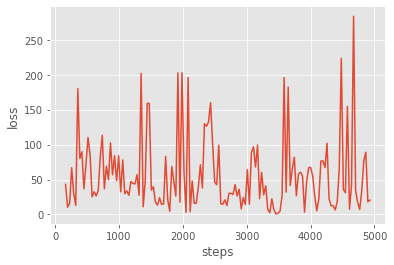

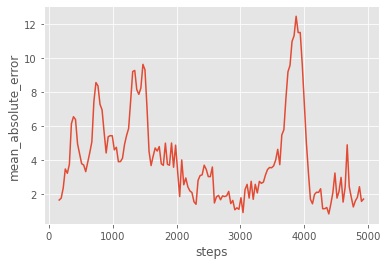

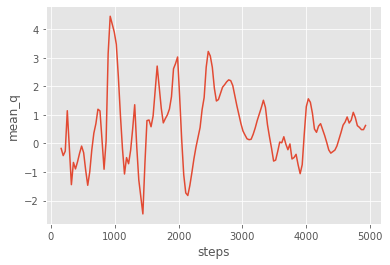

starting train 3
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 64s 64ms/step - reward: 11.2056 - cumulative_reward: -732.4226
train 3 completed. took 228.345 seconds, total_reward: -885.2999999999332 total_profit: 0.8054684815027577
min reward: -158.00000000000037, max reward: 113.19999999999996, mean_reward: -0.17888462315617967


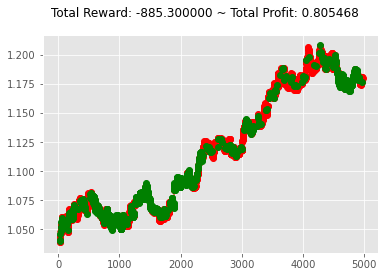

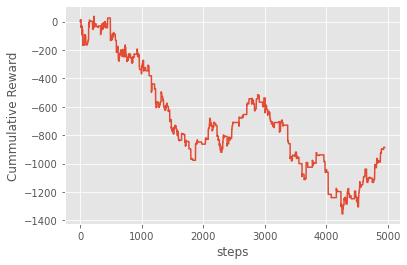

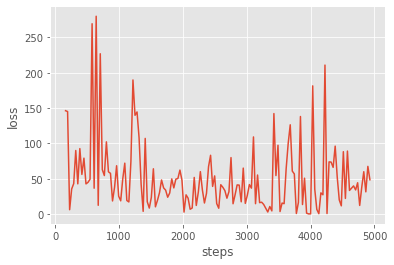

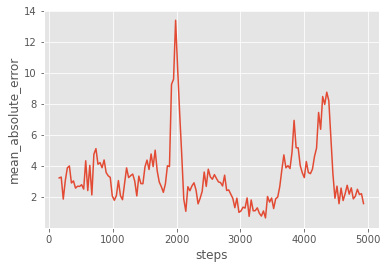

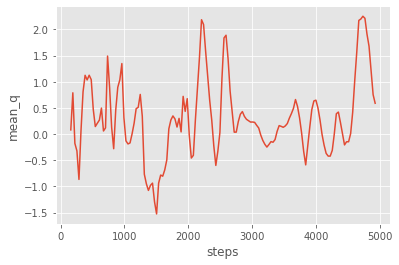

starting train 4
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 66s 67ms/step - reward: 10.5959 - cumulative_reward: 223.47084s - reward: 11.2256 - cum
train 4 completed. took 309.956 seconds, total_reward: 94.89999999996343 total_profit: 0.8287667907135764
min reward: -195.19999999999982, max reward: 120.60000000000181, mean_reward: 0.019175591028483215


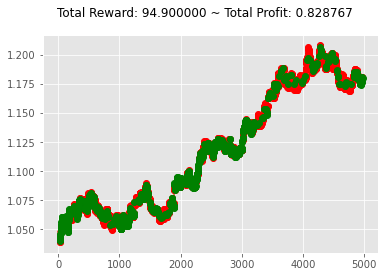

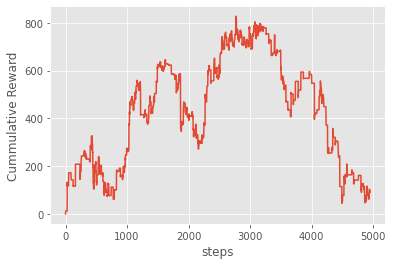

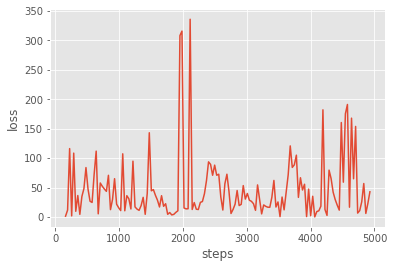

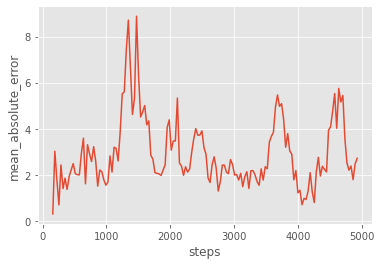

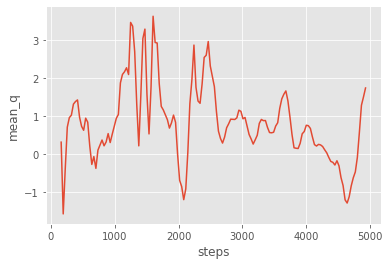

starting train 5
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 70s 71ms/step - reward: -0.0620 - cumulative_reward: -425.4622
train 5 completed. took 395.183 seconds, total_reward: -61.39999999997322 total_profit: 0.859721878982246
min reward: -262.6000000000017, max reward: 183.50000000000088, mean_reward: -0.012406546777121281


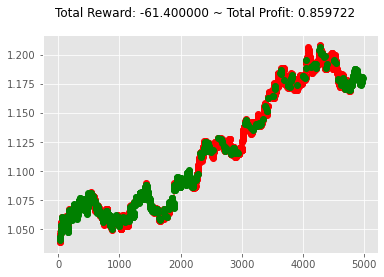

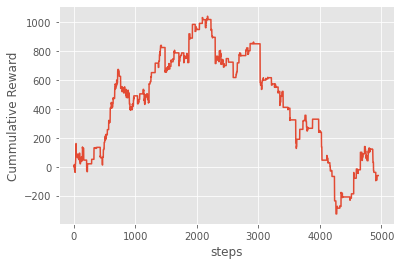

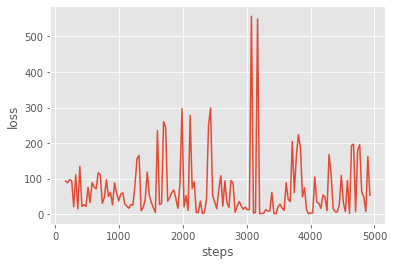

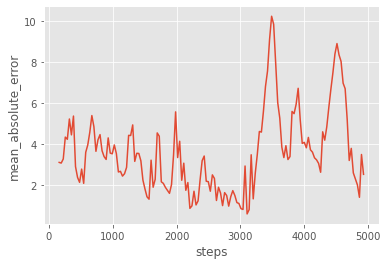

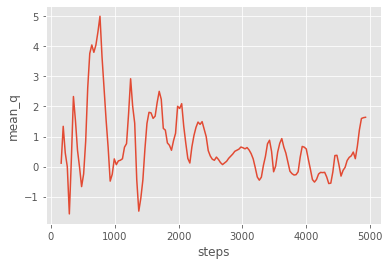

starting train 6
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 68s 69ms/step - reward: -0.3103 - cumulative_reward: -215.8606
train 6 completed. took 477.726 seconds, total_reward: -307.1000000000468 total_profit: 0.802901804525056
min reward: -121.19999999999908, max reward: 139.10000000000088, mean_reward: -0.062052939987885795


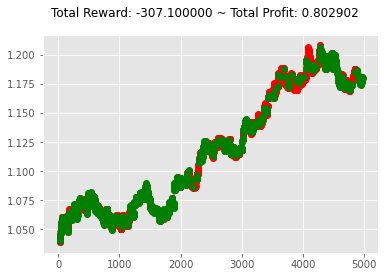

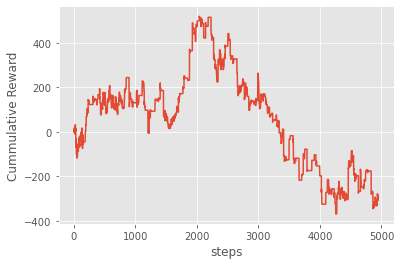

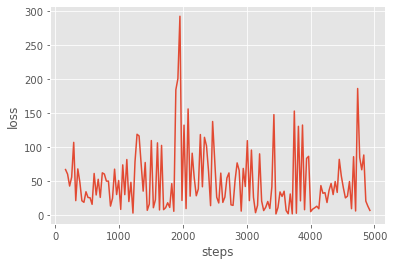

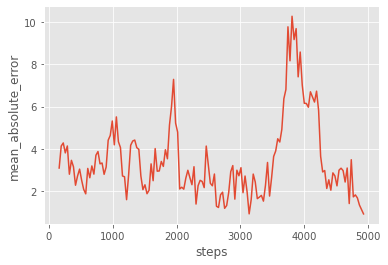

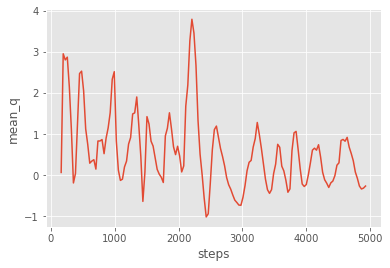

starting train 7
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 68s 69ms/step - reward: 0.9686 - cumulative_reward: 612.8009 17s - re
train 7 completed. took 562.163 seconds, total_reward: 958.7000000000099 total_profit: 0.8783469445725058
min reward: -266.7000000000019, max reward: 159.39999999999844, mean_reward: 0.19371590220246715


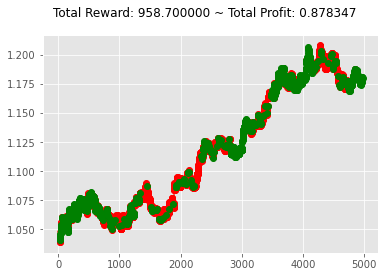

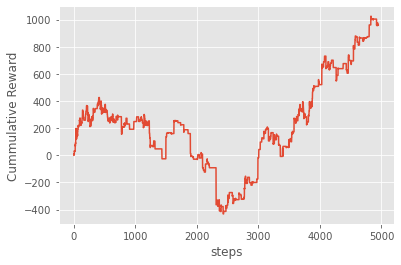

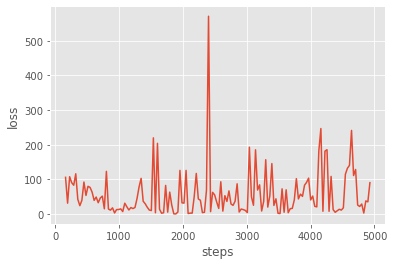

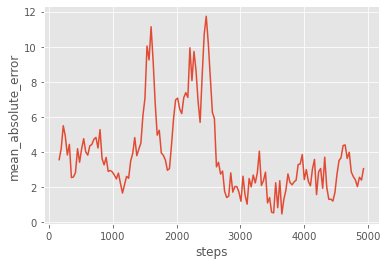

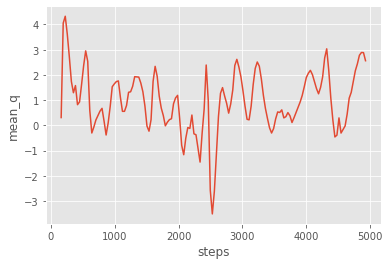

starting train 8
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 68s 69ms/step - reward: 10.4633 - cumulative_reward: -840.6434
train 8 completed. took 644.925 seconds, total_reward: -1619.9999999999734 total_profit: 0.7709884666671025
min reward: -178.6000000000021, max reward: 107.90000000000077, mean_reward: -0.3273388563346077


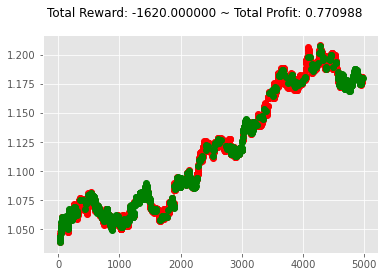

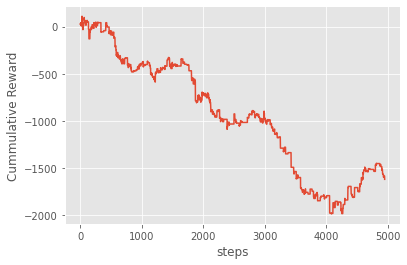

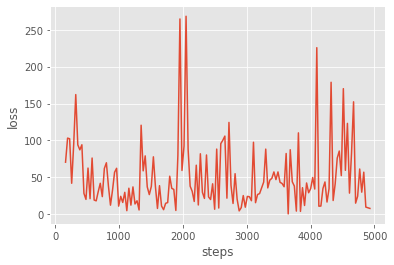

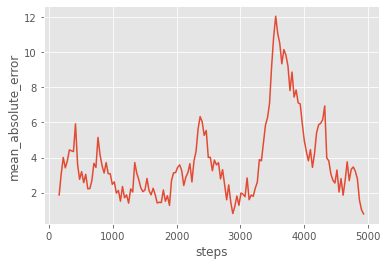

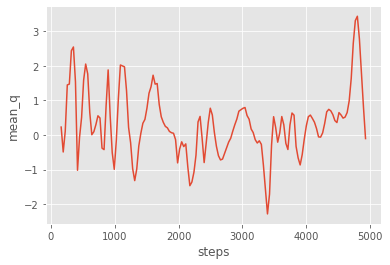

starting train 9
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 72s 73ms/step - reward: -0.2002 - cumulative_reward: -403.6619
train 9 completed. took 733.259 seconds, total_reward: -198.20000000004592 total_profit: 0.8456123714097387
min reward: -152.9999999999987, max reward: 155.6000000000024, mean_reward: -0.04004849464539218


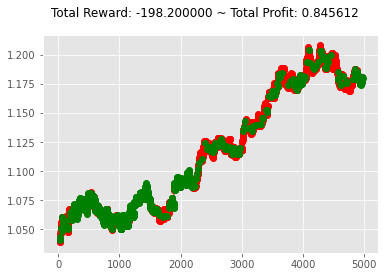

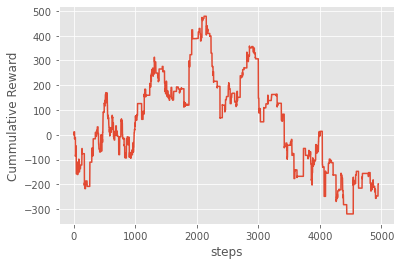

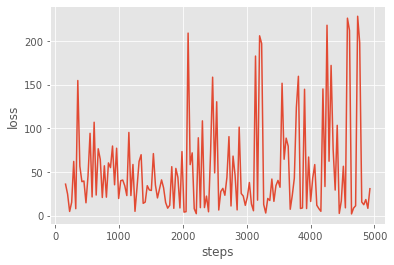

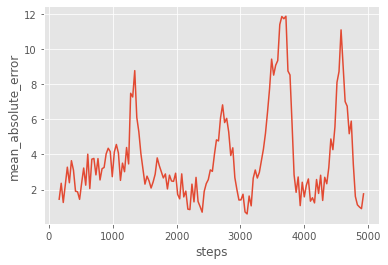

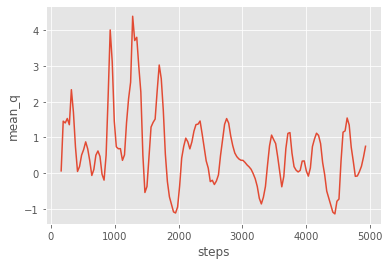

starting train 10
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - ETA: 0s - reward: -0.9909 - cumulative_reward: -395.735 - 75s 76ms/step - reward: -0.9839 - cumulative_reward: -399.8241
train 10 completed. took 825.389 seconds, total_reward: -973.9000000000477 total_profit: 0.8103364907374274
min reward: -191.59999999999843, max reward: 132.49999999999983, mean_reward: -0.19678722974339213


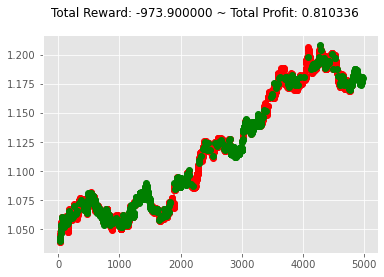

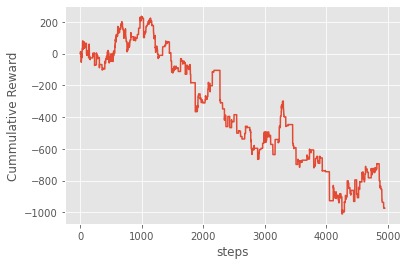

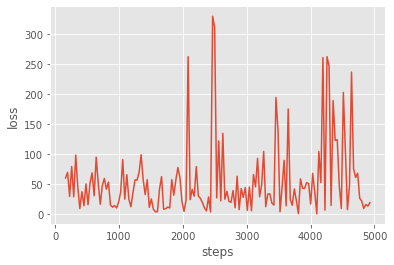

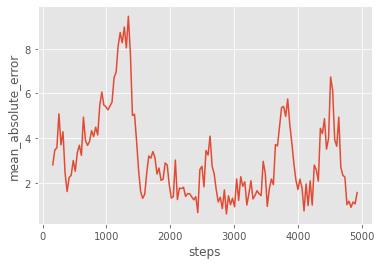

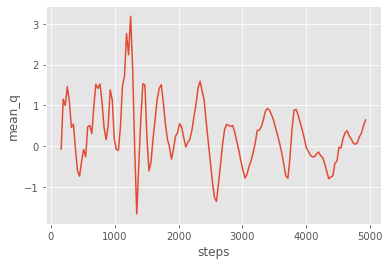

In [8]:
def agent_creator():
    processor = WhiteningNormalizerProcessor()
    memory = SequentialMemory(limit=256, window_length=1)
    policy = EpsGreedyQPolicy()
    agent = DQNAgent(model=buildModel(), nb_actions=nb_actions, memory=memory, nb_steps_warmup=128, policy=policy, batch_size=64, processor=processor, 
                   target_model_update=1e-2, train_interval=32, enable_double_dqn=False, gamma=0.5, enable_dueling_network=True)
    agent.compile(Adam(lr=0.001), metrics=['mae'])
    return agent
e = Evaluator(agent_creator, env_creator, name="dueling_dqn")
e.train(repeat=10)


average of total_reward across trainings: [-344.17]


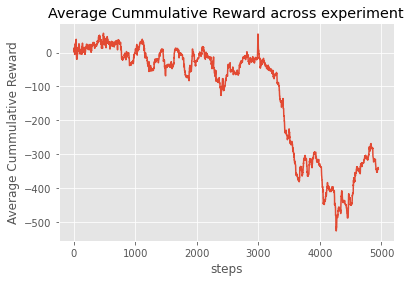

Testing for 1 episodes ...
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
198/199 [============================>.] - ETA: 0s - reward: 0.9864 - cumulative_reward: -96.2278Episode 1: reward: -3.700, steps: 999
test completed. total_reward: -3.6999999999953737 total_profit: 0.9779204921075967
min reward: -117.10000000000109, max reward: 114.30000000000051, mean_reward: -0.0037037037036990726


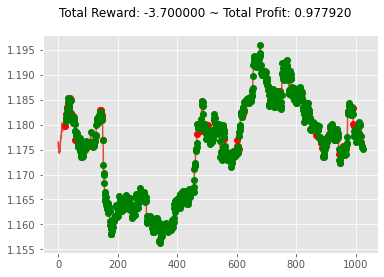

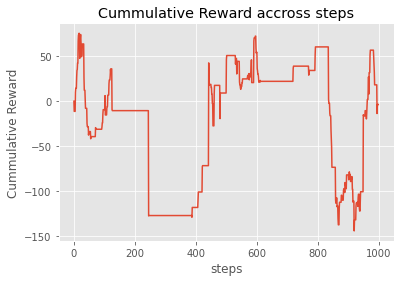

In [9]:
e.process_train_result()
e.test(ForexV0FullFeature(df=FOREX_EURUSD_1H_ASK, frame_bound=(5000, 6000), window_size=24))